In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import seaborn as sns
import ratmetab
if os.getlogin() == 'jonesa7':
    import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if os.getlogin() == 'jonesa7':
    codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
    datapath = {
        'blood': 'blood_27_Oct_2022',
        'brain': 'brain_27_Oct_2022',
        'blood old': 'old_blood_17_Nov_2022',
        'brain old': 'old_brain_17_Nov_2022',
               }
    data = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True) for k, v in datapath.items()}
else:
    datapath_blood = 'some/path'
    datapath_brain = 'some/path'
    codebookpath = 'some/path'

data['brain'].head()

,LIScore,Group,Cholic acid,Taurocholic acid,Taurochenodeoxycholic acid,Tauromuricholic acid (alpha + beta),Carnitine,Acetylcarnitine,Propionylcarnitine,Malonylcarnitine (Hydroxybutyrylcarnitine),...,Phosphatidylethanolamine ae 40:2,Phosphatidylethanolamine ae 42:2,Phosphatidylglycerol aa 32:0,Phosphatidylglycerol aa 34:1,Phosphatidylglycerol aa 36:2,Phosphatidylglycerol aa 36:4,Phosphatidylglycerol aa 38:5,Phosphatidylserine aa 34:1,Phosphatidylserine aa 36:1,Phosphatidylserine aa 40:6
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,NaN,NaN,NaN,NaN,11.034,1.521,NaN,NaN,...,1.146,1.350,0.3983,4.147,0.6962,2.943,0.6260,3.963,23.820,95.495
1158,201,AU,NaN,0.327,0.03300,0.2796,10.904,4.107,0.142000,NaN,...,NaN,1.143,0.3517,3.036,0.5238,2.593,0.5484,4.052,NaN,76.815
1172,155,AU,NaN,0.378,0.01784,0.2104,10.132,4.187,0.072465,0.060798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,194,AU,NaN,0.146,NaN,0.0652,10.024,4.249,0.146000,NaN,...,1.071,1.153,0.3748,3.530,0.5092,2.393,0.5173,3.979,34.066,65.968
127,291,AI,NaN,NaN,NaN,NaN,11.611,3.001,NaN,0.077633,...,1.170,1.413,0.4821,4.428,0.6463,2.665,0.5714,4.618,39.461,93.804


In [3]:
def standardize(dataset, data=data, dropna=False, fillna=True):
    df = data[dataset]
    df = df.sort_values(['Group', 'LIScore'])
    df = df.iloc[:, 2:].transpose()
    std_df = df.apply(lambda x: (x - df.mean(axis=1)) / df.std(axis=1), axis=0)
    std_df = std_df.dropna(axis=0) if dropna else std_df
    std_df = std_df.fillna(0) if fillna else std_df
    return(std_df)

def make_col_colors(std_df, dataset, data=data):
    df = data[dataset]
    group2color = pd.Series(['C0', 'C1', 'C2'], index=['Y', 'AI', 'AU'])
    #group2color = pd.Series(['tab:blue', 'tab:orange', 'tab:green'], index=['Y', 'AI', 'AU'])
    col_colors = group2color.loc[[df.Group.loc[idno] for idno in std_df.columns]]
    return((col_colors, group2color))

def make_row_colors(std_df, codebookpath=codebookpath, min_saturation=0.15):
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    t = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in mcolors.CSS4_COLORS.items())
    t = (x for x in t if x[0][1] >= min_saturation)
    colors = list(x[1] for x in t)
    aclasses = np.unique(codebook.AnalyteClass)
    aclass2color = pd.Series(colors[:: -np.int16(np.ceil(len(colors) / len(aclasses)))], index=aclasses)
    row_colors = codebook.loc[std_df.index, 'AnalyteClass'].apply(lambda x: aclass2color.loc[x])
    return((row_colors, aclass2color))

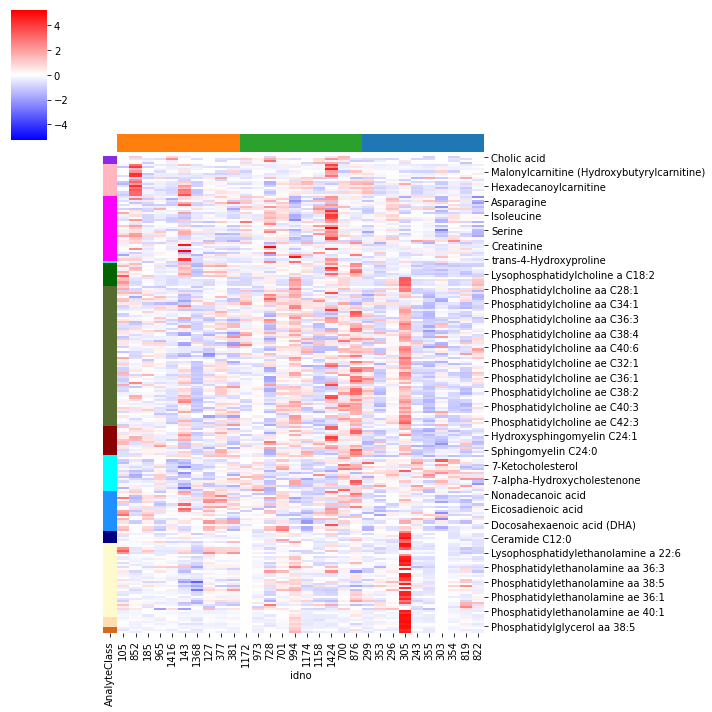

In [4]:
def my_clustermap(dataset, row_cluster=False, col_cluster=False, cmap='bwr'):
    std_df = standardize(dataset)
    row_colors, aclass2color = make_row_colors(std_df)
    col_colors, group2color = make_col_colors(std_df, dataset)
    vmax = std_df.abs().max().max()
    g = sns.clustermap(std_df, row_colors=row_colors, col_colors=col_colors.to_list(), cmap=cmap, row_cluster=row_cluster, col_cluster=col_cluster, vmin=-vmax, vmax=vmax)
    return(g)

g = my_clustermap('brain', row_cluster=False, col_cluster=False)

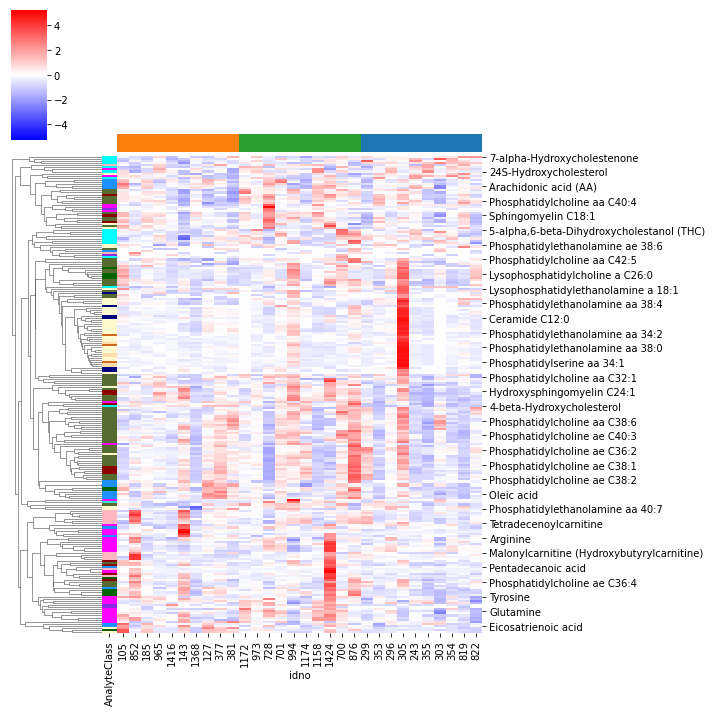

In [5]:
g = my_clustermap('brain', row_cluster=True, col_cluster=False)

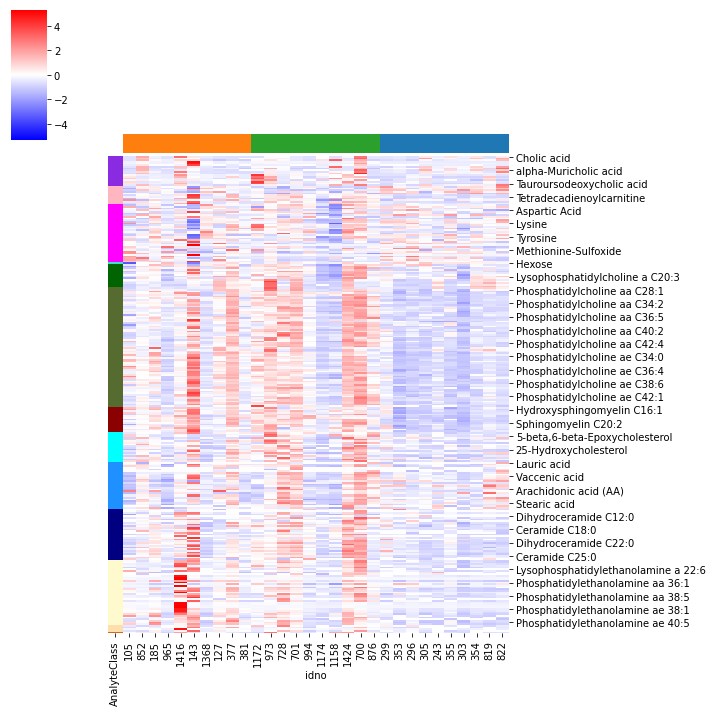

In [6]:
g = my_clustermap('blood', row_cluster=False, col_cluster=False)

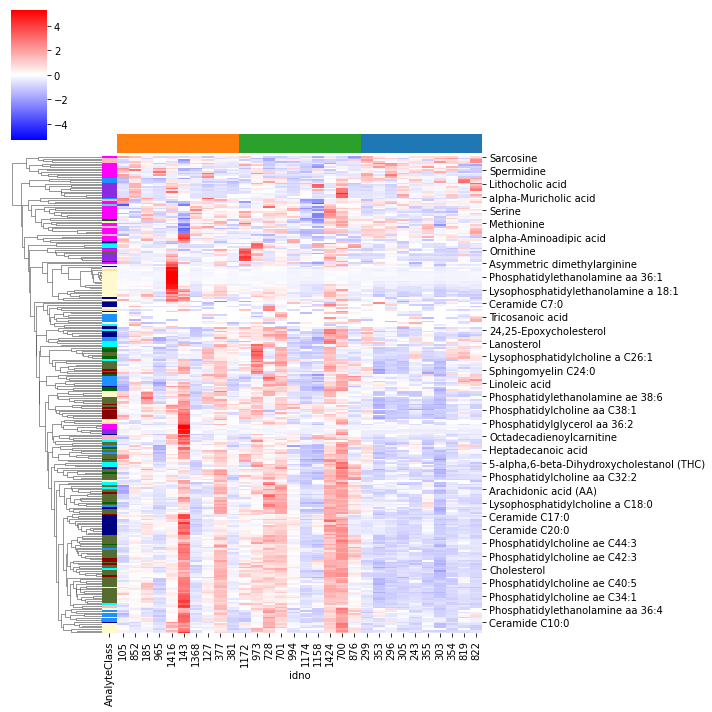

In [7]:
g = my_clustermap('blood', row_cluster=True, col_cluster=False)

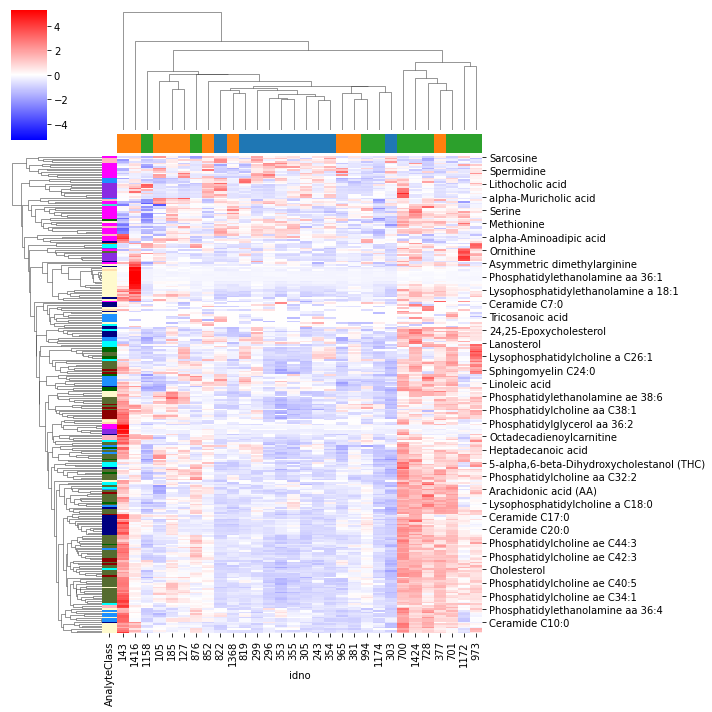

In [8]:
g = my_clustermap('blood', row_cluster=True, col_cluster=True)

In [9]:
%connect_info

{
  "shell_port": 52950,
  "iopub_port": 52951,
  "stdin_port": 52952,
  "control_port": 52954,
  "hb_port": 52953,
  "ip": "127.0.0.1",
  "key": "a0865a9c-a9212fe86d0d059ce1ab6aca",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-aa7e10ae-e17e-4964-a1f4-8e0d44109d47.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
